<a href="https://colab.research.google.com/github/gcunhase/ML-Notebook/blob/master/models/autoencoder_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

## 1. Libraries

*Installing and importing necessary packages*

*Working with **Python 3.6** and **PyTorch 1.0.1** *

In [97]:
import sys
import os
!{sys.executable} -m pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from timeit import default_timer as timer
import numpy as np

print("PyTorch version: {}".format(torch.__version__))
cudnn_enabled = torch.backends.cudnn.enabled
print("CuDNN enabled" if cudnn_enabled else "CuDNN disabled")

PyTorch version: 1.0.1.post2
CuDNN enabled


## 2. Variables

In [114]:
# Make reproducible run
torch.manual_seed(1)

# Settable parameters
params = {'root': './data/',
          'results_dir': './results/',
          'model_type': 'simple',  # simple, convolutional
          'batch_size': 128,
          'epochs': 100,
          'save_ep': 1,
          'lr': 0.001,
          'weight_decay': 5e-4,  # 1e-10,
          'num_classes': 10,
          'hidden_size': [128, 64, 12, 3],
          'input_height': 28,
          'input_width': 28,
          'use_cuda': True,
         }

# GPU usage
print("GPU: {}, number: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))
device = torch.device('cuda') if params['use_cuda'] and torch.cuda.is_available() else torch.device('cpu')

# Ensure results directory exists
if not os.path.exists(params['results_dir']):
    os.mkdir(params['results_dir'])

GPU: True, number: 1


## 3. Dataset

In [115]:
# Get train and test datasets
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(
    root=params['root'],  # directory where the data is or where it will be saved
    train=True,  # train dataset
    download=True,  # download if you don't have it
    transform=trans)  # converts PIL.image or np.ndarray to torch.FloatTensor of shape (C, H, W) and normalizes from (0.0, 1.0)
mnist_test = datasets.MNIST(root=params['root'], train=False, download=True, transform=trans)  # transforms.ToTensor()
print("MNIST Train {}, Test {}".format(len(mnist_train), len(mnist_test)))

# Dataloader: mini-batch during training
mnist_train_dataloader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=params['batch_size'], shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=params['batch_size'], shuffle=True)

MNIST Train 60000, Test 10000


## 4. Model

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        hidden_size = params['hidden_size']
        self.encoder = nn.Sequential(
            nn.Linear(params['input_height'] * params['input_width'], hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.Linear(hidden_size[2], hidden_size[3]),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size[3], hidden_size[2]),
            nn.ReLU(),
            nn.Linear(hidden_size[2], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], params['input_height'] * params['input_width']),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

## 5. Train

epoch [1/100], loss:0.0602
epoch [2/100], loss:0.0608
epoch [3/100], loss:0.0600
epoch [4/100], loss:0.0625
epoch [5/100], loss:0.0584
epoch [6/100], loss:0.0595
epoch [7/100], loss:0.0594
epoch [8/100], loss:0.0602
epoch [9/100], loss:0.0635
epoch [10/100], loss:0.0574
epoch [11/100], loss:0.0607
epoch [12/100], loss:0.0592
epoch [13/100], loss:0.0574
epoch [14/100], loss:0.0607
epoch [15/100], loss:0.0609
epoch [16/100], loss:0.0594
epoch [17/100], loss:0.0627
epoch [18/100], loss:0.0594
epoch [19/100], loss:0.0625
epoch [20/100], loss:0.0615
epoch [21/100], loss:0.0595
epoch [22/100], loss:0.0593
epoch [23/100], loss:0.0610
epoch [24/100], loss:0.0602
epoch [25/100], loss:0.0588
epoch [26/100], loss:0.0592
epoch [27/100], loss:0.0616
epoch [28/100], loss:0.0568
epoch [29/100], loss:0.0601
epoch [30/100], loss:0.0589
epoch [31/100], loss:0.0597
epoch [32/100], loss:0.0574
epoch [33/100], loss:0.0634
epoch [34/100], loss:0.0630
epoch [35/100], loss:0.0582
epoch [36/100], loss:0.0564
e

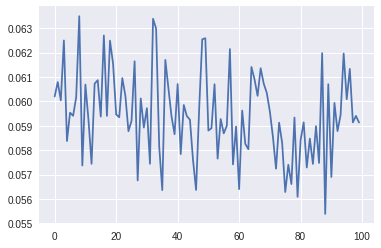

In [117]:
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

loss_arr = []
ep_arr = []
model.zero_grad()
for epoch in range(params['epochs']):
    for i, data in enumerate(mnist_train_dataloader):
        img, _ = data  # bs, 1, 28, 28
        img = img.view(img.size(0), -1)  # bs, 784
        img = img.to(device)
        img = Variable(img).to(device)
        
        # Forward
        output = model(img)
        loss = criterion(output, img)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % params['save_ep'] == 0:
      print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch + 1, params['epochs'], loss.cpu().data))
      loss_arr.append(loss.cpu().data)
      ep_arr.append(epoch)
      
torch.save(model.state_dict(), params['results_dir'] + 'sim_autoencoder.pth')
plt.plot(ep_arr, loss_arr)
plt.show()

## 6. Test

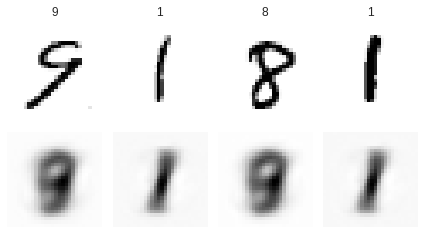

In [119]:
model.eval()

examples = enumerate(mnist_test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

ncols = 4

fig, axes = plt.subplots(nrows=2, ncols=ncols)
for i, ax in enumerate(axes.flat):
  # Original images
  if i < ncols:
    idx = i
    img = example_data[idx][0]
  else:  # Reconstructed images
    idx = i-ncols
    img = example_data[idx][0]
    img = img.view(-1)
    img = img.to(device)
  
    output = model(img)
    pic = output.cpu().data
    pic = pic.view(-1, params['input_height'], params['input_width'])
    img = pic[0]  
    
  ax.imshow(img)
  if i < ncols:
    ax.set_title('{}'.format(example_targets[idx]))
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()